In [1]:
# Project Template Import Cell
%matplotlib inline
import os
import sys
import math

from __future__ import print_function, division
from inspect import getsourcefile

from IPython.display import FileLink

# Standard Notebook Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

CURR_PATH = os.path.abspath(getsourcefile(lambda:0)).rsplit('/', 1)[0] # Get filepath of this notebook
module_path = os.path.join(os.path.dirname(CURR_PATH), 'utils') # Make module path for one dir up and one down into utils
if module_path not in sys.path: # Append to system path list
    sys.path.append(module_path)

import utils as utils ; reload(utils)

print('System : Python ', os.sys.version , '\n\n')

print('Directory Structure:')
print(CURR_PATH)
!tree -cn --filelimit 12

# Keras Setup
import keras
print('\n\nKeras version:' , keras.__version__ ,
      ', backend:' , keras.backend.backend(),
      ', image_format:' , keras.backend.image_data_format())

random_seed = 2

print('\n\nEnvironment : ')
FileLink('../../ana_py27_p2.yml')

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


System : Python  2.7.12 | packaged by conda-forge | (default, Sep  8 2016, 14:22:31) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)] 


Directory Structure:
/home/ubuntu/ana_py27_p2/projects/CervicalCancer
.
├── unused_utils
│   ├── __init__.py
│   ├── __init__.pyc
│   ├── utils.pyc
│   └── unused_utils.py
├── __init__.py
├── 001 - Initial Setup.ipynb
├── data
│   ├── additional_Type_1_v2.7z
│   ├── additional_Type_3_v2.7z
│   ├── additional_Type_2_v2.7z
│   ├── train
│   │   ├── Type_1 [168 entries exceeds filelimit, not opening dir]
│   │   ├── Type_2 [524 entries exceeds filelimit, not opening dir]
│   │   └── Type_3 [302 entries exceeds filelimit, not opening dir]
│   ├── test
│   │   └── unknown [512 entries exceeds filelimit, not opening dir]
│   ├── preview
│   ├── downloads
│   │   ├── sample_submission.csv.zip
│   │   ├── test.7z
│   │   └── train.7z
│   ├── valid
│   │   ├── Type_1 [82 entries exceeds filelimit, not opening dir]
│   │   ├── Type_2 [257 entries exceeds filelimit, not

/home/ubuntu/ana_py27_p2/ana_py27_p2.yml

In [2]:
# A fix for truncated image error
# http://stackoverflow.com/questions/12984426/python-pil-ioerror-image-file-truncated-with-big-images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
# http://www.pyimagesearch.com/2016/08/08/k-nn-classifier-for-image-classification/
# http://opencv-python-tutroals.readthedocs.io/
#                                 en/latest/py_tutorials/py_ml/py_knn/py_knn_opencv/py_knn_opencv.html#knn-opencv
import cv2
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble import VotingClassifier # Use after a few classifiers have been selected

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold

In [4]:
# Get Image Paths

# !!!SAMPLE
train_data_dir = 'data/sample/train' ; validation_data_dir = 'data/sample/valid' ; test_data_dir = 'data/sample/test'
weights_dir = 'data/sample/weights'

# !!!TRAIN
#train_data_dir = 'data/train' ; validation_data_dir = 'data/valid' ; test_data_dir = 'data/test' 
#weights_dir = 'data/weights' ; submission_dir = 'data/submissions'

# Make a list of test_image_paths
test_image_paths = utils.get_non_hidden_dir_contents(os.path.join(test_data_dir, 'unknown'))
print('Test Images')
print(len(test_image_paths))
print(test_image_paths[0:4])


# Make a list of all classified image paths
data_dirs = utils.get_non_hidden_dir_contents(train_data_dir)
data_dirs.extend(utils.get_non_hidden_dir_contents(validation_data_dir))
# Make a nested list and flatten it
full_image_paths = sum([[image_path for image_path in utils.get_non_hidden_dir_contents(data_dir)] 
                       for data_dir in data_dirs],[])
print('Classified Images')
print(len(full_image_paths))
print(full_image_paths[0:4])

Test Images
201
['data/sample/test/unknown/3_1409.jpg', 'data/sample/test/unknown/2_1046.jpg', 'data/sample/test/unknown/2_933.jpg', 'data/sample/test/unknown/2_1407.jpg']
Classified Images
835
['data/sample/train/Type_2/905.jpg', 'data/sample/train/Type_2/1180.jpg', 'data/sample/train/Type_2/777.jpg', 'data/sample/train/Type_2/1313.jpg']


In [5]:
# Make a DataFrame for convenience
data_df = pd.DataFrame(full_image_paths, columns =['path'])
data_df['Type'] = data_df['path'].apply(lambda x: int(x.split('/')[-2].split('_')[1])-1)

print(data_df.head(2))
print(data_df.tail(2))
# Shuffle the DataFrame before taking a sample
data_df = data_df.sample(frac=1,random_state=random_seed)


# Take sample
#data_df = data_df.head(100)

                                path  Type
0   data/sample/train/Type_2/905.jpg     1
1  data/sample/train/Type_2/1180.jpg     1
                                 path  Type
833  data/sample/valid/Type_1/783.jpg     0
834   data/sample/valid/Type_1/57.jpg     0


In [6]:
import cv2
# Split into Train & Test Samples
X = data_df['path'].values
y = data_df['Type'].values
skf = StratifiedKFold(y, shuffle=True, n_folds = 10, random_state=random_seed)
print(X[0:1][0])
print(y[0:4])
hsv = cv2.imread(X[0:1][0])
print(type(X[0:1]))

data/sample/valid/Type_1/751.jpg
[0 1 2 2]
<type 'numpy.ndarray'>


In [7]:
class_weight_dict = utils.get_class_weight_dict([168, 524, 302])
print(class_weight_dict) # = {1: 3.03, 2: 1.0, 3: 1.71}

{0: 3.119047619047619, 1: 1.0, 2: 1.7350993377483444}


In [8]:
# http://stackoverflow.com/questions/31259891/put-customized-functions-in-sklearn-pipeline
# Feature extraction function
from sklearn.base import BaseEstimator, TransformerMixin

class Extract_Color_Histogram(BaseEstimator, TransformerMixin):
    def __init__(self, bin_s = 8, size=32):
        self.bin_s = bin_s
        self.size=size
    def transform(self, X, *_):
        """
        Accepts X a numpy array of image paths
        cv2.resize(img, (32,32).flatten()
        
        """
        # To store data as it is being generated
        X_data = []
        for image_path in X:
            img_array = cv2.imread(image_path)#, cv2.COLOR_BGR2HSV)
            # Resize downwards
            img_array = cv2.resize(img_array, (self.size,self.size))
            # Convert to hsv space
            hsv = cv2.cvtColor(img_array, cv2.COLOR_BGR2HSV)
            # Get the hsv histograms
            hist = cv2.calcHist([hsv], [0,1,2], None, (self.bin_s,self.bin_s,self.bin_s), [0, 180, 0, 256, 0,256])
            # Normalize the histograms
            cv2.normalize(hist, hist)
            # Flatten the histograms
            X_data.append(hist.flatten())
        ret_array = np.array(X_data)
        return ret_array
    def fit(self, *_):
        return self

In [9]:
# Create the pipeline
etc_estimators = []
etc_estimators.append(('Extract_Color_Histogram', Extract_Color_Histogram()))
etc_estimators.append(('ExtraTreesClassifier', ExtraTreesClassifier(criterion='gini',
                                                                n_estimators=20,
                                                                oob_score = True,
                                                                bootstrap=True, 
                                                                n_jobs=-1,
                                                                class_weight='balanced_subsample',
                                                                random_state = random_seed)))
etc_clf = Pipeline(etc_estimators)

In [10]:
# Create the pipeline
svc_estimators = []
svc_estimators.append(('Extract_Color_Histogram', Extract_Color_Histogram()))
svc_estimators.append(('SVC', SVC(C = 0.01,
                                  kernel='rbf',
                                  degree = 3,
                                  probability=True,
                                  decision_function_shape='ovr', 
                                  class_weight=class_weight_dict,
                                  random_state = random_seed)))
svc_clf = Pipeline(svc_estimators)

In [11]:
# Create the pipeline
knn_estimators = []
knn_estimators.append(('Extract_Color_Histogram', Extract_Color_Histogram()))
knn_estimators.append(('SVC', KNeighborsClassifier(n_neighbors = 5,
                                                   weights='distance',
                                                   algorithm='auto',
                                                   n_jobs = -1)))
knn_clf = Pipeline(knn_estimators)

In [12]:
# Create the pipeline
gnb_estimators = []
gnb_estimators.append(('Extract_Color_Histogram', Extract_Color_Histogram()))
gnb_estimators.append(('GNB', GaussianNB()))
gnb_clf = Pipeline(gnb_estimators)

In [13]:
# Create the pipeline
rfc_estimators = []
rfc_estimators.append(('Extract_Color_Histogram', Extract_Color_Histogram()))
rfc_estimators.append(('RFC', RandomForestClassifier(n_estimators=20,
                                                     criterion='entropy',
                                                     random_state=random_seed,
                                                     warm_start=True,
                                                     class_weight = class_weight_dict,
                                                     bootstrap=True,
                                                     oob_score=True,
                                                     n_jobs = -1)))
rcf_clf = Pipeline(rfc_estimators)

In [14]:
# Create the pipeline
gbc_estimators = []
gbc_estimators.append(('Extract_Color_Histogram', Extract_Color_Histogram()))
gbc_estimators.append(('RFC', GradientBoostingClassifier(loss='deviance',
                                                         learning_rate=0.1,
                                                         n_estimators=20,
                                                         max_depth=3,
                                                         max_features='auto',
                                                         warm_start=True,
                                                         random_state=random_seed)))
gbc_clf = Pipeline(gbc_estimators)

In [15]:
# Use this for preliminary timing on the AWS p2 instance, so can estimate a good size for the sample directory files
import time
start_time = time.time()

In [16]:
all_names = ['ETC', 'SVC', 'KNN', 'GNB', 'RCF', 'GBC']
all_results = []
all_results.append(cross_val_score(etc_clf, X, y, cv=skf))
print('Part Completed', all_results[-1])
all_results.append(cross_val_score(svc_clf, X, y, cv=skf))
print('Part Completed', all_results[-1])
all_results.append(cross_val_score(knn_clf, X, y, cv=skf))
print('Part Completed', all_results[-1])
all_results.append(cross_val_score(gnb_clf, X, y, cv=skf))
print('Part Completed', all_results[-1])
all_results.append(cross_val_score(rcf_clf, X, y, cv=skf))
print('Part Completed', all_results[-1])
all_results.append(cross_val_score(gbc_clf, X, y, cv=skf))
print('Part Completed', all_results[-1])

Part Completed [ 0.5294  0.5595  0.5476  0.5357  0.5301  0.5904  0.5663  0.5663  0.5783
  0.5422]
Part Completed [ 0.5176  0.1667  0.1667  0.1667  0.3012  0.3012  0.3012  0.3012  0.3012
  0.3012]
Part Completed [ 0.4471  0.4286  0.5952  0.619   0.4458  0.5422  0.5181  0.5783  0.506
  0.5301]
Part Completed [ 0.3647  0.3452  0.3452  0.4167  0.3133  0.4337  0.3373  0.4458  0.4096
  0.3012]
Part Completed [ 0.5647  0.5119  0.619   0.6071  0.4337  0.5542  0.5181  0.5904  0.5663
  0.4819]
Part Completed [ 0.5765  0.4643  0.5833  0.5476  0.3976  0.5422  0.5663  0.5422  0.6145
  0.5783]


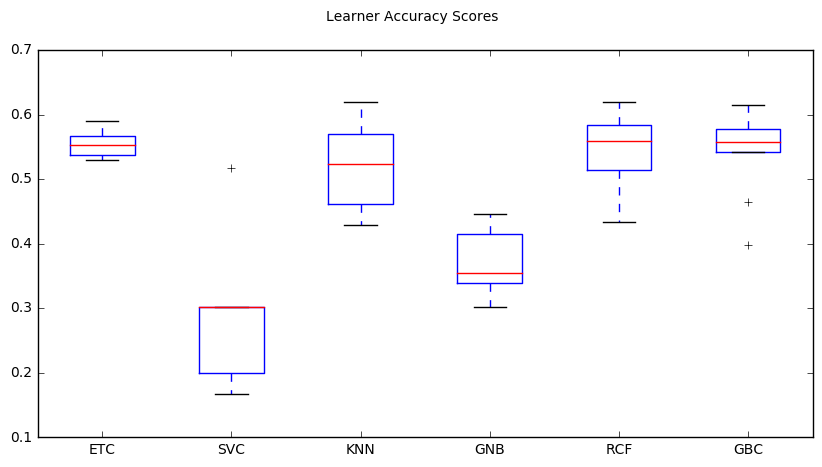

In [17]:
# Plot Results
fig = plt.figure(figsize=(10,5))
fig.suptitle('Learner Accuracy Scores')
ax = fig.add_subplot(111)
plt.boxplot(all_results)
ax.set_xticklabels(all_names)
plt.show();

In [18]:
# Use this for preliminary timing on the AWS p2 instance, so can estimate a good size for the sample directory files
print("%f seconds" % (time.time() - start_time))
print('Total Images Processed %d'  % y.shape[0])

10636.559404 seconds
Total Images Processed 835
